In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import joblib

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Bibliotecas dos Modelos Utilizados
from sklearn.linear_model import LogisticRegression  # Regressão Logística.
from sklearn.svm import SVC                          # Máquinas de Vetores de Suporte (SVM).
from sklearn.neighbors import KNeighborsClassifier   # K-Vizinhos Mais Próximos
from sklearn.tree import DecisionTreeClassifier      # Árvore de Decisões de Classificação.
from sklearn.ensemble import RandomForestClassifier  # Floresta Aleatória.
from xgboost import XGBClassifier                    # Extreme Gradient Boosting.

In [3]:
# Análise de Dados
from sklearn.decomposition import PCA

# Treinamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Avalição
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import label_binarize

# Tuning
from sklearn.model_selection import GridSearchCV

# Análise de Dados

In [29]:
# Carregar o DataFrame a partir de um arquivo Excel
caminho_arquivo_excel = 'C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\anonymizedData.xlsx'
nome_da_pagina = 'P_Tracao'  # Nome da página desejada

# Lê o arquivo Excel com todas as páginas/sheets
xl = pd.ExcelFile(caminho_arquivo_excel)

df = xl.parse(nome_da_pagina)

# Vê dados 
df.head()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Bitola Traseira,DP_Altura,DP_Comprimento,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,DMV_Lado Direito,...,CD_Distancia de frenagem de 35 a 0 em asfalto,CD_Distancia de frenagem de 35 a 0 em terra batida,CD_Ganho de rolagem por aceleracao lateral,CD_Ganho de arfagem em aceleracao longitudinal,CD_Ganho de arfagem em desaceleracao longitudinal,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Tracao
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1381.306200,1400.000000,1336.700433,1485.149012,2033.803036,582.270289,78.744569,110.649690,0.390286,0.511169,...,NaN,NaN,4.324657,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1333.646128,1400.000000,1344.118231,1494.898329,2030.875266,589.559597,77.362570,113.253684,0.391539,0.512543,...,NaN,NaN,5.318897,NaN,NaN,NaN,NaN,NaN,NaN,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1501.031945,1321.957851,1236.117841,1357.110969,1932.820439,NaN,69.779501,94.943599,0.439284,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.604391,4.905901,1


In [30]:
# Remove as colunas que não trazem dados relevantes as provas
colunas_a_remover = [
    'DP_Entre-Eixo',
    'DP_Bitola Dianteira',
    'DP_Bitola Traseira',
    'DP_Altura',
    'DP_Comprimento',
    'DMV_Lado Direito',
    'SD_Dimensoes dos pneus',
    'SD_Cambagem estatica',
    'SD_Convergência estatica',
    'ST_Dimensoes dos pneus',
    'ST_Cambagem estatica',
    'ST_Convergência estatica',
    'D_Relacao',
    'D_Curso total da cremalheira',
    'D_Inclinacao do pino mestre',
    'D_Angulo de caster',
    'FD_Pressao no sistema a 07g ',
    'FD_Forca no pedal a 07g ',
    'FD_Curso total do pedal ',
    'FD_Diametro do disco ',
    'FT_Pressao no sistema a 07g ',
    'FT_Diametro do disco ',
    'CD_Raio mínimo de curva do protótipo',
    'CD_Distancia de frenagem de 35 a 0 em asfalto',
    'CD_Distancia de frenagem de 35 a 0 em terra batida',
    'CD_Velocidade crítica para uma curva de raio de 10 m',
    'CD_Ganho de rolagem por aceleracao lateral',
    'CD_Ganho de arfagem em aceleracao longitudinal', 
    'CD_Ganho de arfagem em desaceleracao longitudinal'
]

# Remove as colunas especificadas
df = df.drop(colunas_a_remover, axis=1)

In [23]:
# Informação básica
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   DP_Altura do CG com relacao ao chao                      231 non-null    float64
 1   MV_Eixo dianteiro                                        726 non-null    float64
 2   MV_Eixo Traseiro                                         726 non-null    float64
 3   DMV_Dianteira                                            726 non-null    float64
 4   PCG_X                                                    726 non-null    float64
 5   PCG_Y                                                    973 non-null    float64
 6   PCG_Z                                                    726 non-null    float64
 7   SD_Curso Positivo de projeto                             125 non-null    float64
 8   SD_Curso Negativo de projeto 

In [8]:
# Descrição de dados
df.describe()

,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,PCG_X,PCG_Y,PCG_Z,SD_Curso Positivo de projeto,SD_Curso Negativo de projeto,ST_Curso Positivo de projeto,ST_Curso Negativo de projeto,MT_Potência maxima do motor,MT_Torque maximo do motor,MT_Relacao total_max,MT_Relacao total_min,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Tracao
count,231.000000,726.000000,726.000000,726.000000,726.000000,973.000000,726.000000,125.000000,125.000000,127.000000,122.000000,249.000000,253.000000,720.000000,716.000000,344.000000,279.000000,286.000000,258.000000,1000.000000
mean,536.659805,73.933830,104.141418,0.415669,265.583113,116.313810,-38.721956,146.280278,58.277663,138.309376,47.257070,7.075005,19.164095,28.645560,5.816134,51.338339,48.526226,7.520008,8.157341,3.000000
std,101.333409,11.279547,13.646792,0.026451,224.815288,198.889258,5945.125750,40.232393,17.325487,44.653487,14.736924,0.381772,1.154163,5.510778,1.240431,4.476562,5.581954,4.181862,4.829979,1.414921
min,292.610000,48.185803,76.072417,0.327360,-268.343676,-106.854976,-141682.766178,40.000000,19.000000,22.072990,17.763000,5.137429,14.685439,3.291627,0.777981,40.246896,26.957654,3.778791,3.489945,1.000000
25%,492.656885,67.892521,95.526348,0.398516,91.264042,-0.476839,171.402440,127.294449,48.151855,103.400000,37.010982,6.874160,18.607156,26.544004,4.973951,47.259536,44.333294,4.686999,4.929826,2.000000
50%,532.369245,72.023435,103.061604,0.413962,180.908122,6.762149,251.144260,148.876071,54.353007,145.000000,46.480275,7.076627,18.779886,28.798765,5.770713,51.779603,49.115975,6.145469,6.738506,3.000000
75%,569.083727,79.139310,110.465185,0.435021,422.804395,169.694760,382.331462,172.047372,74.658013,170.684204,50.000000,7.414085,19.510563,31.534882,6.571716,55.094668,52.723070,9.055245,9.360602,4.000000
max,1024.146490,132.106420,163.996866,0.481743,863.791114,1028.393380,994.853698,326.501752,103.095996,224.373954,89.907768,7.780000,23.140000,54.690048,9.826116,67.091994,61.252327,28.800000,31.700000,5.000000


In [10]:
# Inicialize um dicionário para armazenar o número de zeros em cada coluna
contagem_zeros = {}

# Loop através de todas as colunas
for coluna in df.columns:
    # Use a função sum() para contar a quantidade de zeros (0) na coluna
    zeros_na_coluna = (df[coluna] == 0).sum()
    
    # Armazene o resultado no dicionário
    contagem_zeros[coluna] = zeros_na_coluna

# Exiba a contagem de zeros em cada coluna
for coluna, zeros in contagem_zeros.items():
    print(f"'{coluna}' tem {zeros}.")    

'DP_Altura do CG com relacao ao chao' tem 0.
'MV_Eixo dianteiro' tem 0.
'MV_Eixo Traseiro' tem 0.
'DMV_Dianteira' tem 0.
'PCG_X' tem 0.
'PCG_Y' tem 15.
'PCG_Z' tem 0.
'SD_Curso Positivo de projeto' tem 0.
'SD_Curso Negativo de projeto' tem 0.
'ST_Curso Positivo de projeto' tem 0.
'ST_Curso Negativo de projeto' tem 0.
'MT_Potência maxima do motor' tem 0.
'MT_Torque maximo do motor' tem 0.
'MT_Relacao total_max' tem 0.
'MT_Relacao total_min' tem 0.
'CD_Velocidade maxima de 0 a 100 metros em asfalto ' tem 0.
'CD_Velocidade maxima de 0 a 100 metros em terra batida ' tem 0.
'CD_Tempo para atingir velocidade maxima em asfalto' tem 0.
'CD_Tempo para atingir velocidade maxima em terra batida' tem 0.
'P_Tracao' tem 0.


## Limpeza

In [31]:
# Limpar o Dataset das colunas com muitos valores nulos

limite_nulos = 900 # Define o limite de valores nulos permitidos

# Remove as colunas com mais de limite_nulos valores nulos
df = df.dropna(thresh=len(df) - limite_nulos, axis=1)

# Checar 
df.isnull().sum()

DP_Altura do CG com relacao ao chao                        769
MV_Eixo dianteiro                                          274
MV_Eixo Traseiro                                           274
DMV_Dianteira                                              274
PCG_X                                                      274
PCG_Y                                                       27
PCG_Z                                                      274
SD_Curso Positivo de projeto                               875
SD_Curso Negativo de projeto                               875
ST_Curso Positivo de projeto                               873
ST_Curso Negativo de projeto                               878
MT_Potência maxima do motor                                751
MT_Torque maximo do motor                                  747
MT_Relacao total_max                                       280
MT_Relacao total_min                                       284
CD_Velocidade maxima de 0 a 100 metros em asfalto      

In [32]:
# Verifique quais linhas têm mais de 8 valores iguais nulos
linhas_quase_nulas = df[df.isnull().sum(axis=1) > 8]

# Exiba as linhas que atendem à condição
print(linhas_quase_nulas.index)

# Exclua as linhas com base nos índices coletados
df = df.drop(linhas_quase_nulas.index)

# Exiba o DataFrame resultante
print(df)

Int64Index([  0,   3,   4,   5,   6,   7,   8,  11,  13,  14,
            ...
            984, 986, 988, 989, 990, 991, 992, 994, 997, 999],
           dtype='int64', length=578)
     DP_Altura do CG com relacao ao chao  MV_Eixo dianteiro  MV_Eixo Traseiro  \
1                             582.270289          78.744569        110.649690   
2                             589.559597          77.362570        113.253684   
9                             419.766151         122.289083        138.833062   
10                                   NaN          88.332169        100.813723   
12                                   NaN          70.143112        103.380460   
..                                   ...                ...               ...   
987                                  NaN          67.692876         88.975463   
993                                  NaN          70.225517         98.444700   
995                           548.012531          59.428353         85.431119   
996        

In [33]:
# Mapeie os valores existentes para os novos valores
mapeamento = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

# Use a função 'replace' para fazer a substituição
df['P_Tracao'] = df['P_Tracao'].replace(mapeamento)

print(df['P_Tracao'])

1      0
2      0
9      0
10     0
12     0
      ..
987    4
993    4
995    4
996    4
998    4
Name: P_Tracao, Length: 422, dtype: int64


In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado.xlsx"

# Salvar o DataFrame na planilha 'P_Aceleration'
df.to_excel(caminho_arquivo, sheet_name='P_Aceleration', index=False)

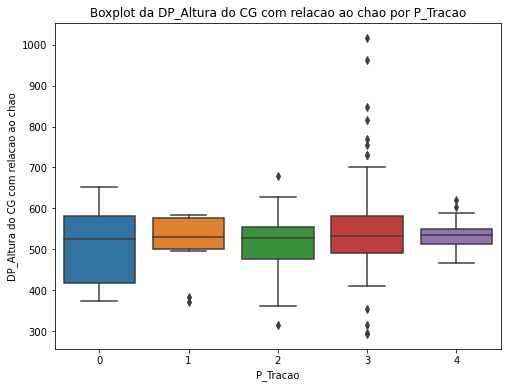

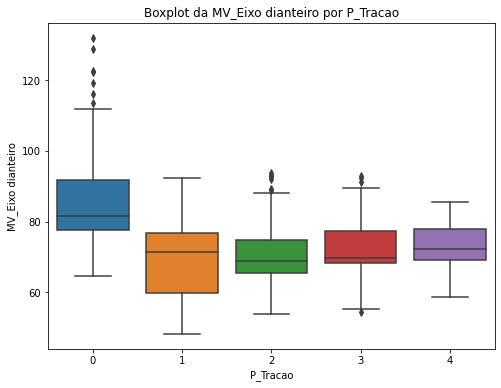

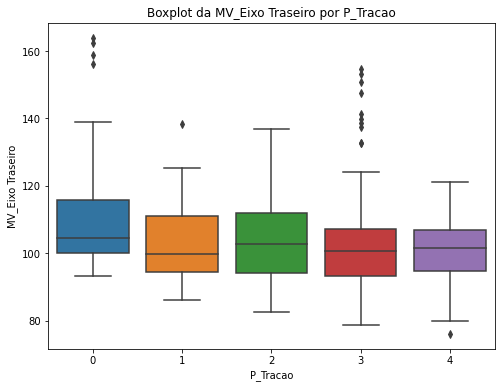

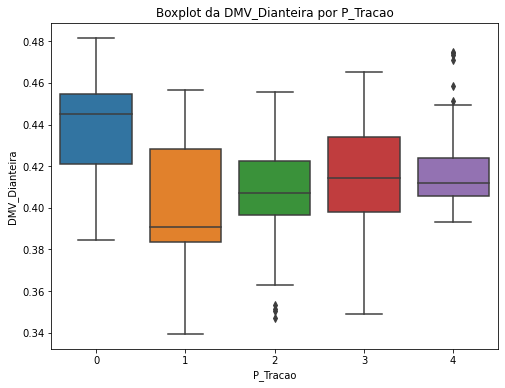

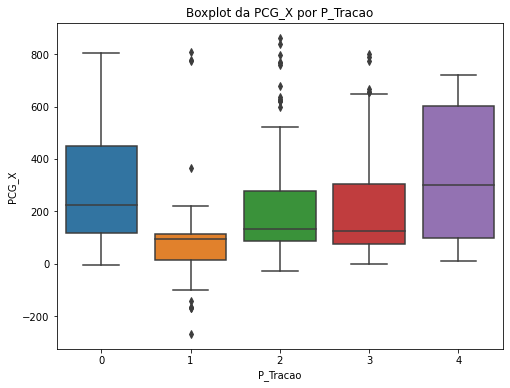

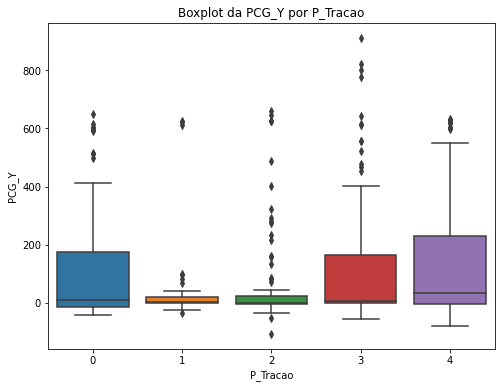

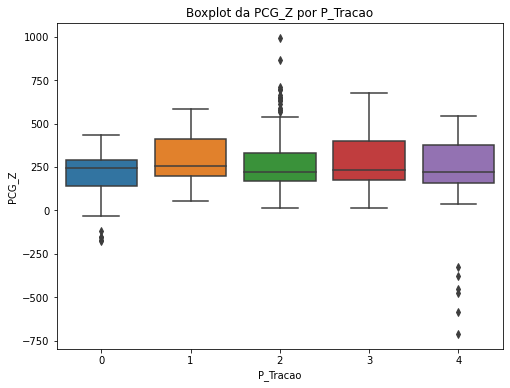

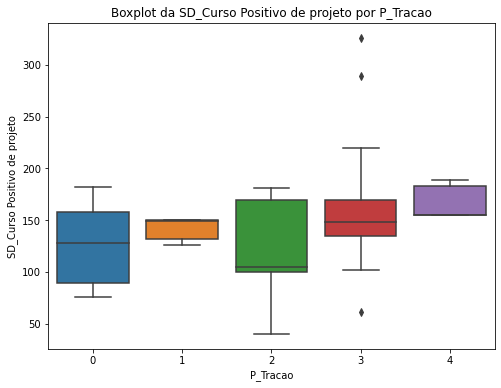

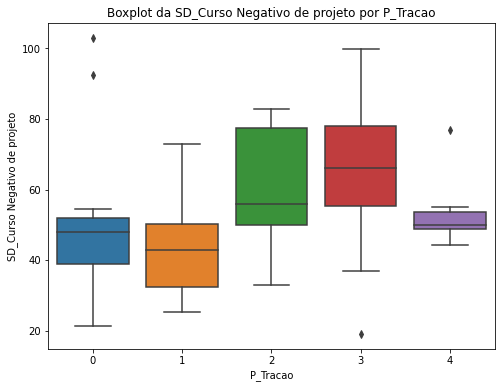

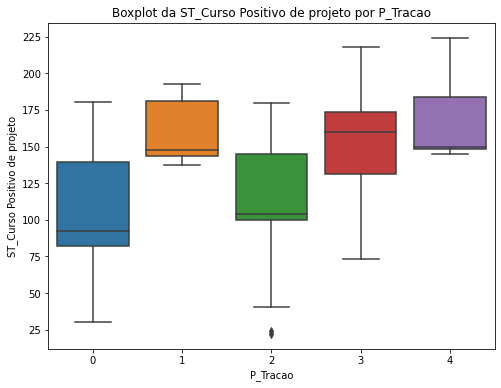

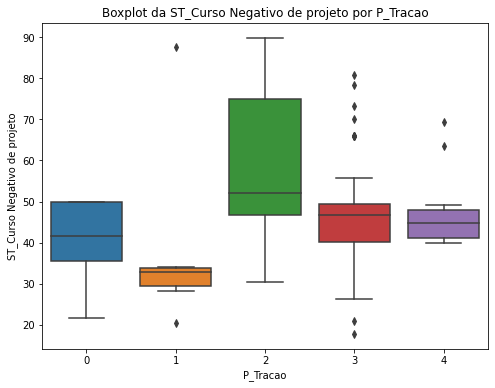

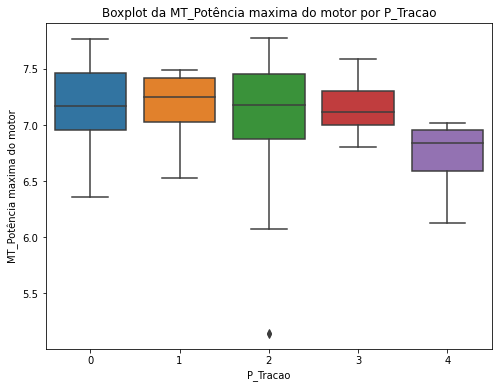

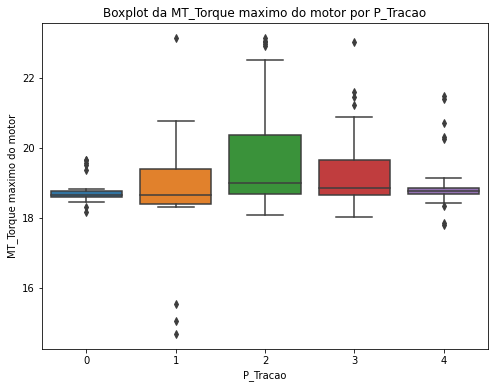

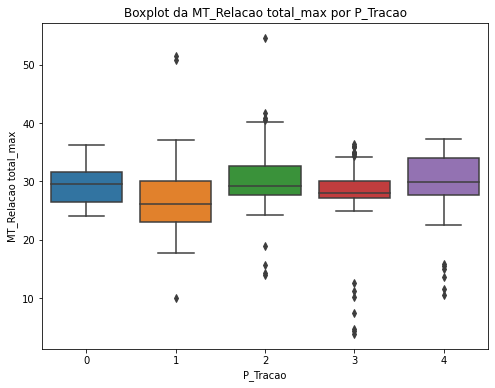

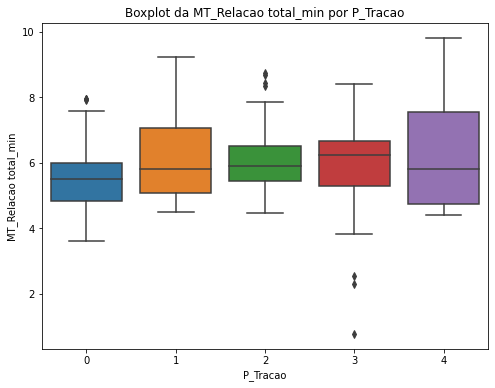

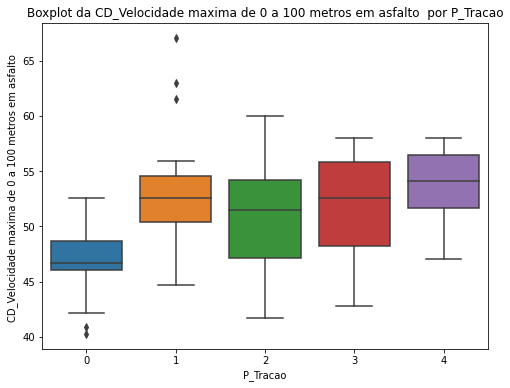

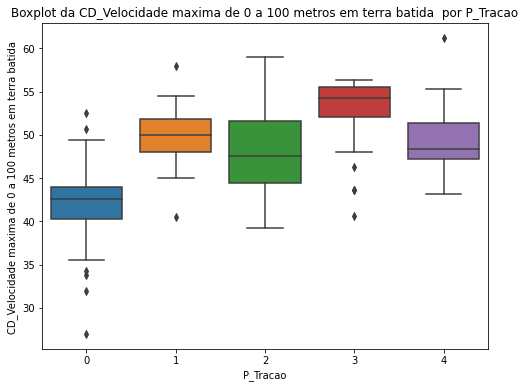

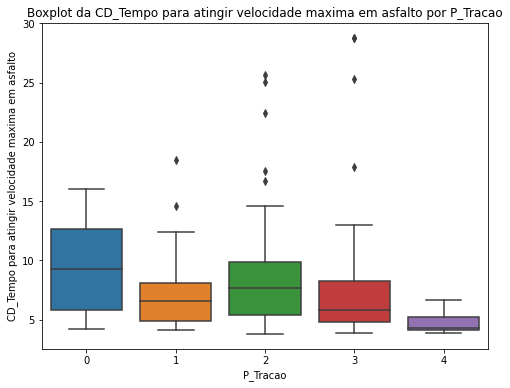

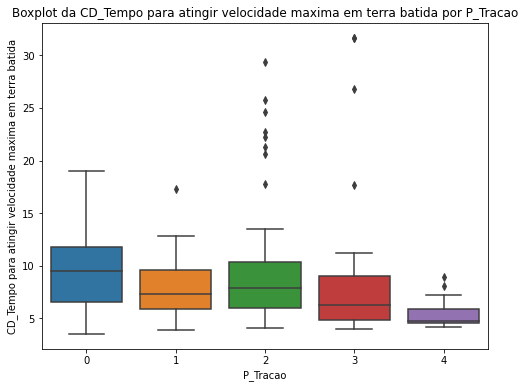

In [14]:
# Boxplots por Classes
for coluna in df.columns:
    if coluna != 'P_Tracao':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Tracao', y=coluna, data=df)
        plt.title(f'Boxplot da {coluna} por P_Tracao')
        plt.ylabel(coluna)
        plt.xlabel('P_Tracao')
        plt.show()

In [34]:
# Tratar Outliers e valores nulos
colunas_a_tratar = df.columns.difference(['P_Tracao']) # Lista das colunas a serem tratadas 


# Lista das classes únicas na coluna 'Classe'
classes_unicas = df['P_Tracao'].unique()

# Função para tratar uma coluna específica em uma classe
def tratar_coluna_para_classe(data, classe, coluna):
    dados_classe = data[data['P_Tracao'] == classe]
    
    # Calcula a mediana dos valores não nulos da coluna para esta classe
    mediana = dados_classe[coluna].median()
    
    # Calcula o desvio padrão dos valores não nulos da coluna para esta classe
    desvio_padrao = dados_classe[coluna].std()
    
    # Define o limite superior e inferior com base no desvio padrão
    limite_superior = mediana + (2 * desvio_padrao)
    limite_inferior = mediana - (2 * desvio_padrao)
    
    # Substitui os valores que são nulos ou estão fora do limite pelo valor da mediana
    dados_classe[coluna] = dados_classe[coluna].apply(lambda x: mediana if pd.isna(x) or x > limite_superior or x < limite_inferior else x)
    
    return dados_classe

# Loop para tratar todas as colunas para cada classe
dados_tratados = []
for classe in classes_unicas:
    dados_classe = df[df['P_Tracao'] == classe].copy()  # Crie uma cópia dos dados da classe
    for coluna in colunas_a_tratar:
        dados_classe = tratar_coluna_para_classe(dados_classe, classe, coluna)
    dados_tratados.append(dados_classe)

# Concatena os dados tratados de volta em um único DataFrame
df_tratado = pd.concat(dados_tratados)

#print(df)

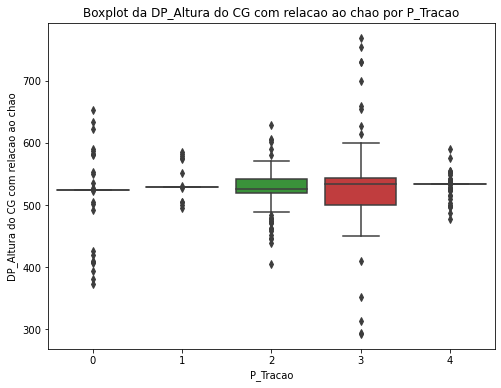

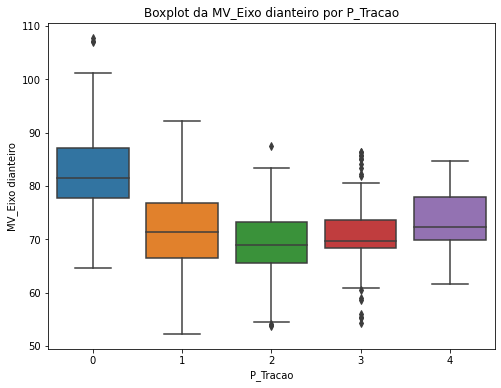

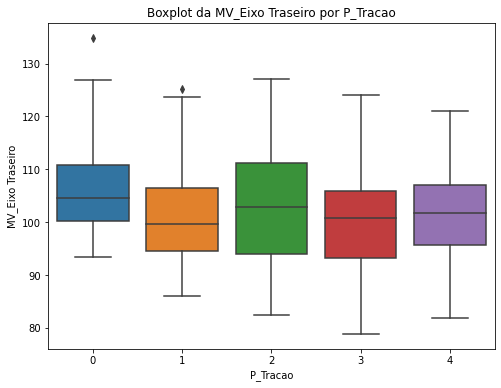

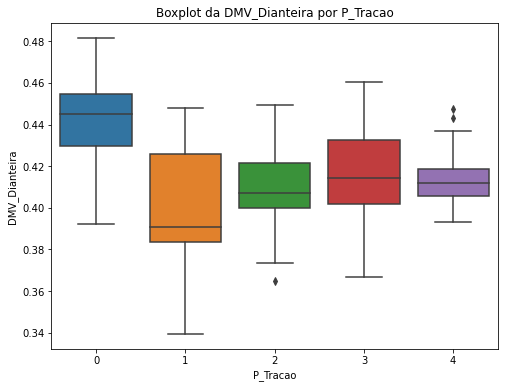

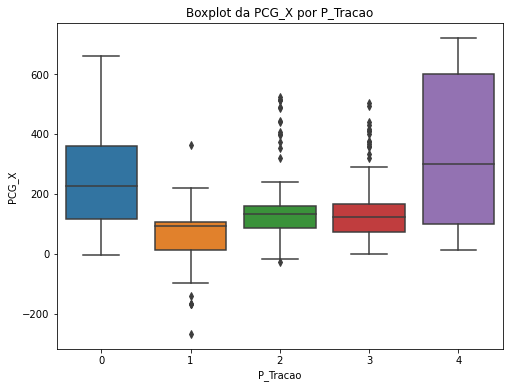

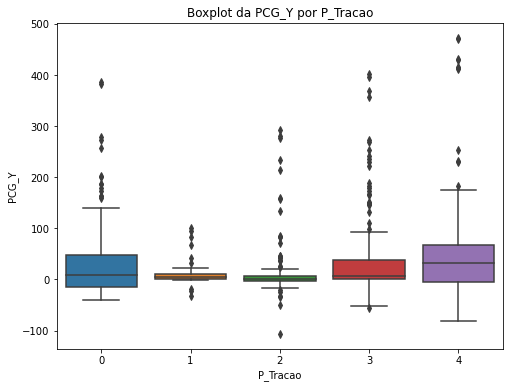

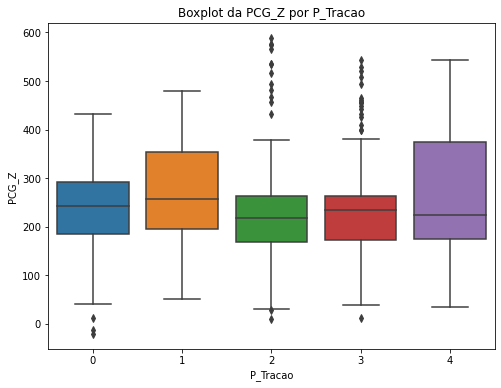

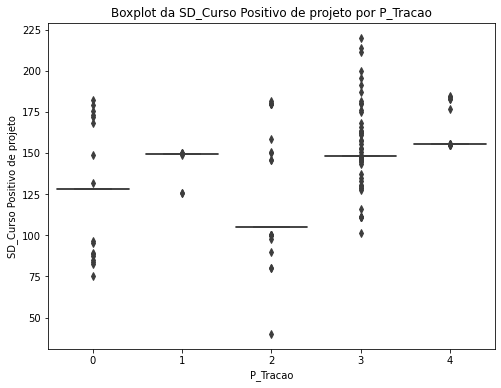

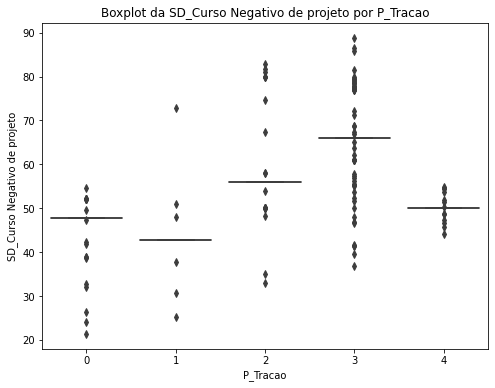

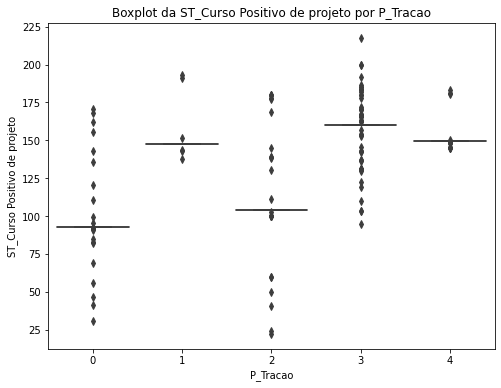

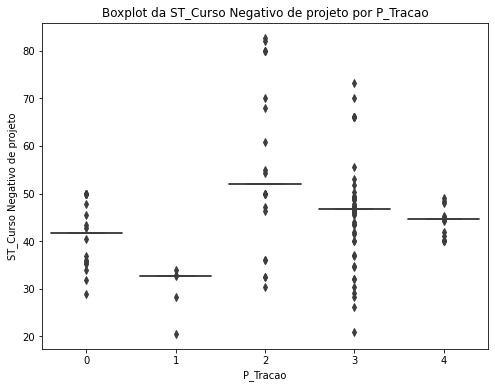

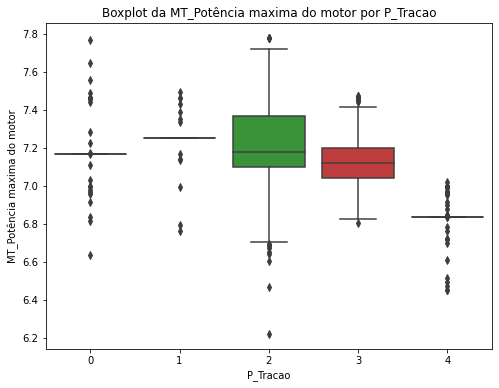

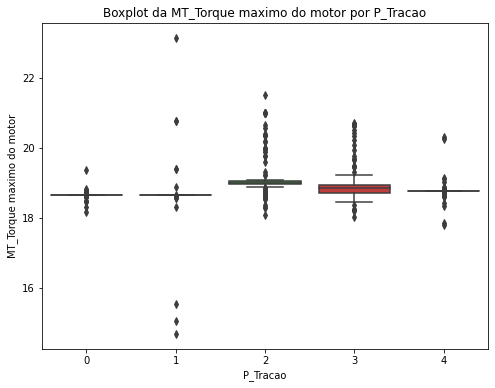

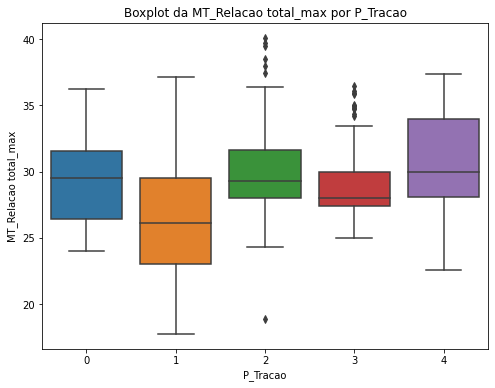

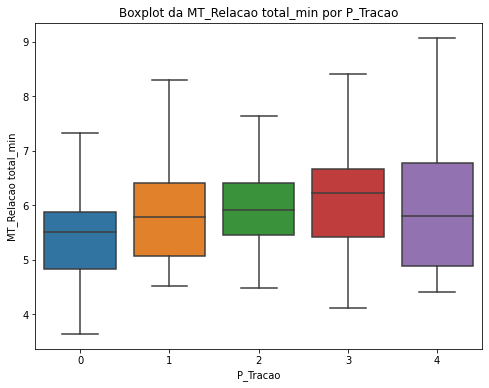

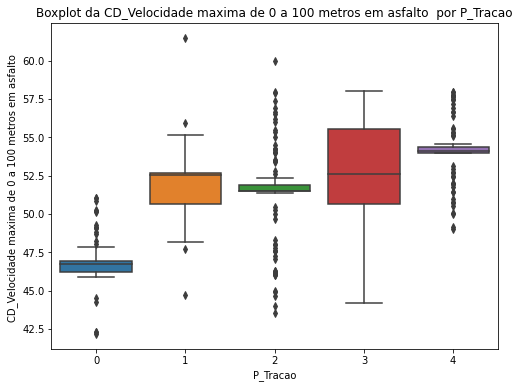

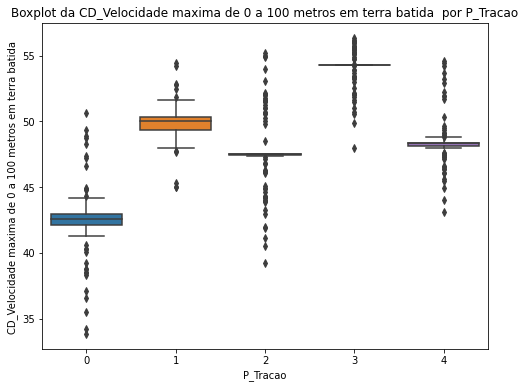

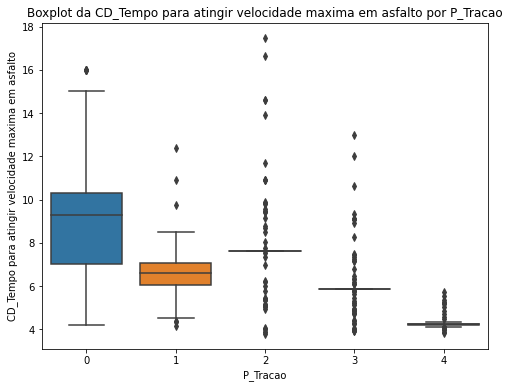

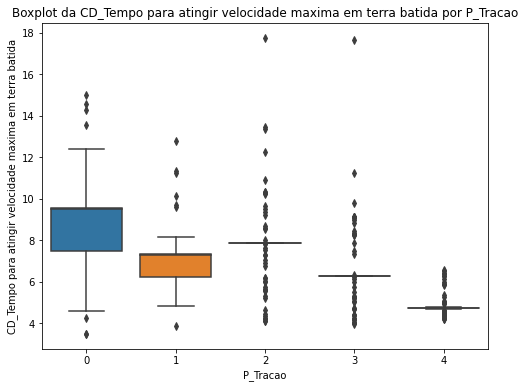

In [16]:
# Boxplots por Classes
for coluna in df_tratado.columns:
    if coluna != 'P_Tracao':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Tracao', y=coluna, data=df_tratado)
        plt.title(f'Boxplot da {coluna} por P_Tracao')
        plt.ylabel(coluna)
        plt.xlabel('P_Tracao')
        plt.show()

In [35]:
df = df_tratado

In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado_semO.xlsx"

# Carregar o arquivo Excel existente
book = load_workbook(caminho_arquivo)

# Adicionar o DataFrame como um novo sheet
with pd.ExcelWriter(caminho_arquivo, engine='openpyxl', mode='a') as writer:
    writer.book = book
    novo_dataframe.to_excel(writer, sheet_name='P_Velocidade', index=False)

## Análise de Variáveis

In [36]:
data_corr = df.drop(['P_Tracao'], axis=1)
# Análise de correlação dos parâmetros
correlation = df.corr()

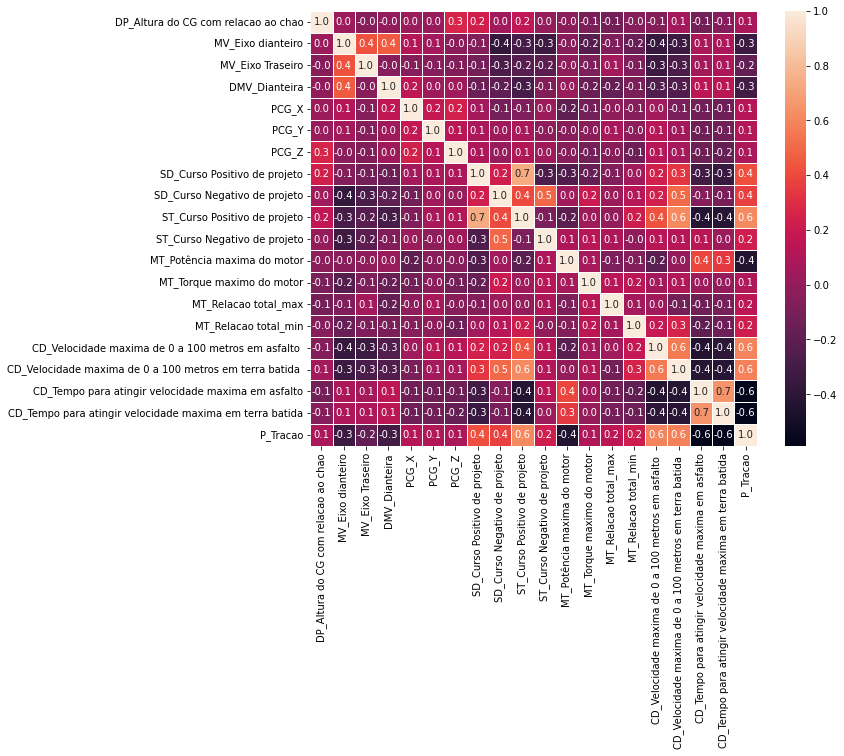

In [37]:
# Plot da matriz de correlação
plt.figure(figsize=(10, 8))

plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=0.5)
plt.show()

In [38]:
# Aplicar PCA para reduzir variáveis de alta correlação - Massa
variaveis_reduzidas = df[['MV_Eixo dianteiro', 'MV_Eixo Traseiro']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'MV_Eixo dianteiro',
    'MV_Eixo Traseiro',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 1

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Massa', variavel_reduzida)

print(df)

     DP_Altura do CG com relacao ao chao      Massa  DMV_Dianteira  \
1                             582.270289  10.445908       0.445076   
2                             589.559597  11.786158       0.445076   
9                             419.766151   7.044088       0.470594   
10                            524.944722   7.888669       0.450733   
12                            524.944722  -0.442437       0.473082   
..                                   ...        ...            ...   
987                           534.242772 -13.647397       0.447492   
993                           534.242772  -4.438161       0.420099   
995                           548.012531 -13.877511       0.423888   
996                           534.242772  -8.333629       0.400910   
998                           534.242772  -7.543314       0.408075   

          PCG_X       PCG_Y       PCG_Z  SD_Curso Positivo de projeto  \
1    109.203162  -22.428785  248.526573                    172.047372   
2    108.3659

In [39]:
# Aplicar PCA para reduzir variáveis de alta correlação - Curso Positivo de projeto
variaveis_reduzidas = df[['SD_Curso Positivo de projeto', 'ST_Curso Positivo de projeto']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'SD_Curso Positivo de projeto',
    'ST_Curso Positivo de projeto',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 6

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Curso Positivo de projeto', variavel_reduzida)

print(df)

     DP_Altura do CG com relacao ao chao      Massa  DMV_Dianteira  \
1                             582.270289  10.445908       0.445076   
2                             589.559597  11.786158       0.445076   
9                             419.766151   7.044088       0.470594   
10                            524.944722   7.888669       0.450733   
12                            524.944722  -0.442437       0.473082   
..                                   ...        ...            ...   
987                           534.242772 -13.647397       0.447492   
993                           534.242772  -4.438161       0.420099   
995                           548.012531 -13.877511       0.423888   
996                           534.242772  -8.333629       0.400910   
998                           534.242772  -7.543314       0.408075   

          PCG_X       PCG_Y       PCG_Z  Curso Positivo de projeto  \
1    109.203162  -22.428785  248.526573                 -30.405096   
2    108.365923  -1

In [40]:
# Aplicar PCA para reduzir variáveis de alta correlação - Curso Negativo de projeto
variaveis_reduzidas = df[['SD_Curso Negativo de projeto', 'ST_Curso Negativo de projeto']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'SD_Curso Negativo de projeto',
    'ST_Curso Negativo de projeto',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 7

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Curso Negativo de projeto', variavel_reduzida)

print(df)

     DP_Altura do CG com relacao ao chao      Massa  DMV_Dianteira  \
1                             582.270289  10.445908       0.445076   
2                             589.559597  11.786158       0.445076   
9                             419.766151   7.044088       0.470594   
10                            524.944722   7.888669       0.450733   
12                            524.944722  -0.442437       0.473082   
..                                   ...        ...            ...   
987                           534.242772 -13.647397       0.447492   
993                           534.242772  -4.438161       0.420099   
995                           548.012531 -13.877511       0.423888   
996                           534.242772  -8.333629       0.400910   
998                           534.242772  -7.543314       0.408075   

          PCG_X       PCG_Y       PCG_Z  Curso Positivo de projeto  \
1    109.203162  -22.428785  248.526573                 -30.405096   
2    108.365923  -1

In [41]:
# Aplicar PCA para reduzir variáveis de alta correlação - CD_Velocidade maxima de 0 a 100 metros
variaveis_reduzidas = df[['CD_Velocidade maxima de 0 a 100 metros em terra batida ', 'CD_Velocidade maxima de 0 a 100 metros em asfalto ']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'CD_Velocidade maxima de 0 a 100 metros em terra batida ',
    'CD_Velocidade maxima de 0 a 100 metros em asfalto ',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 12

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'CD_Velocidade maxima de 0 a 100 metros', variavel_reduzida)

print(df)

     DP_Altura do CG com relacao ao chao      Massa  DMV_Dianteira  \
1                             582.270289  10.445908       0.445076   
2                             589.559597  11.786158       0.445076   
9                             419.766151   7.044088       0.470594   
10                            524.944722   7.888669       0.450733   
12                            524.944722  -0.442437       0.473082   
..                                   ...        ...            ...   
987                           534.242772 -13.647397       0.447492   
993                           534.242772  -4.438161       0.420099   
995                           548.012531 -13.877511       0.423888   
996                           534.242772  -8.333629       0.400910   
998                           534.242772  -7.543314       0.408075   

          PCG_X       PCG_Y       PCG_Z  Curso Positivo de projeto  \
1    109.203162  -22.428785  248.526573                 -30.405096   
2    108.365923  -1

In [42]:
# Aplicar PCA para reduzir variáveis de alta correlação - CD_Tempo para atingir velocidade maxima
variaveis_reduzidas = df[['CD_Tempo para atingir velocidade maxima em asfalto', 'CD_Tempo para atingir velocidade maxima em terra batida']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'CD_Tempo para atingir velocidade maxima em asfalto',
    'CD_Tempo para atingir velocidade maxima em terra batida',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 13

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'CD_Tempo para atingir velocidade maxima', variavel_reduzida)

print(df)

     DP_Altura do CG com relacao ao chao      Massa  DMV_Dianteira  \
1                             582.270289  10.445908       0.445076   
2                             589.559597  11.786158       0.445076   
9                             419.766151   7.044088       0.470594   
10                            524.944722   7.888669       0.450733   
12                            524.944722  -0.442437       0.473082   
..                                   ...        ...            ...   
987                           534.242772 -13.647397       0.447492   
993                           534.242772  -4.438161       0.420099   
995                           548.012531 -13.877511       0.423888   
996                           534.242772  -8.333629       0.400910   
998                           534.242772  -7.543314       0.408075   

          PCG_X       PCG_Y       PCG_Z  Curso Positivo de projeto  \
1    109.203162  -22.428785  248.526573                 -30.405096   
2    108.365923  -1

In [43]:
# Dividir o conjunto de dados em treinamento e teste
dados_treino, dados_teste = train_test_split(df, test_size=0.3)

# Separar X e Y
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

X_treino = dados_treino.iloc[:, :-1]
Y_treino = dados_treino.iloc[:, -1]

X_teste = dados_teste.iloc[:, :-1]
Y_teste = dados_teste.iloc[:, -1]

print(dados_treino)

     DP_Altura do CG com relacao ao chao      Massa  DMV_Dianteira  \
703                           539.548260   8.257535       0.397793   
121                           553.338582   8.429441       0.433198   
472                           526.455148  14.764220       0.404551   
927                           538.109450   6.488935       0.406148   
599                           542.000000   9.451324       0.400158   
..                                   ...        ...            ...   
993                           534.242772  -4.438161       0.420099   
789                           658.767992  -2.796657       0.391987   
859                           534.242772   2.568066       0.423753   
172                           524.944722   2.753980       0.444949   
917                           534.242772   0.782513       0.406909   

          PCG_X       PCG_Y       PCG_Z  Curso Positivo de projeto  \
703  103.990902   18.914963  256.762783                 -30.499484   
121  151.817928  -2

# Escolha do Modelo

## Regressão Logística:

In [44]:
# Modelo de regressão logística.
model_LR = LogisticRegression()
model_LR.fit(X_treino, Y_treino)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [45]:
# Avaliação do desempenho do modelo.
Y_pred = model_LR.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Regressão Logística:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Regressão Logística:
Acurácia: 0.82
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        26
           1       0.88      0.70      0.78        10
           2       0.79      0.76      0.78        25
           3       0.77      0.89      0.82        37
           4       0.85      0.79      0.82        29

    accuracy                           0.82       127
   macro avg       0.83      0.80      0.81       127
weighted avg       0.82      0.82      0.82       127



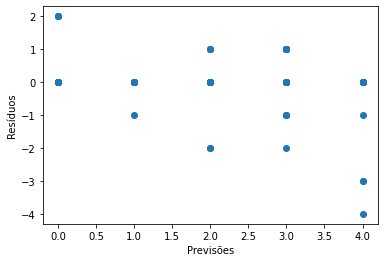

In [46]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## Máquinas de Vetores de Suporte (SVM)

In [47]:
# Modelo SVM com um kernel linear e "um contra todos"
model_SVM = SVC(kernel='linear', decision_function_shape='ovr')
model_SVM.fit(X_treino, Y_treino)

SVC(kernel='linear')

In [48]:
# Avaliação do desempenho do modelo.
Y_pred = model_SVM.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Máquinas de Vetores de Suporte:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Máquinas de Vetores de Suporte:
Acurácia: 0.93
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93        26
           1       1.00      0.80      0.89        10
           2       0.84      0.84      0.84        25
           3       0.95      0.95      0.95        37
           4       1.00      1.00      1.00        29

    accuracy                           0.93       127
   macro avg       0.94      0.91      0.92       127
weighted avg       0.93      0.93      0.93       127



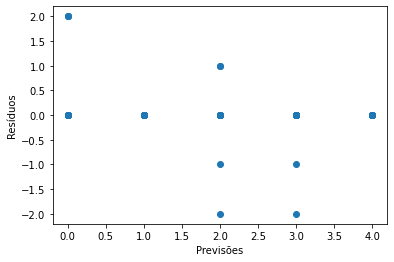

In [49]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## K-Nearest Neighbors

In [50]:
k = 3  # Número de vizinhos (Altere por necessidade)

# Modelo de K-Vizinhos Mais Próximos (K-Nearest Neighbors - KNN).
model_KNN = KNeighborsClassifier(n_neighbors=k)
model_KNN.fit(X_treino, Y_treino)

KNeighborsClassifier(n_neighbors=3)

In [51]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_KNN.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para K-Vizinhos Mais Próximos:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para K-Vizinhos Mais Próximos:
Acurácia: 0.68
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70        26
           1       0.45      1.00      0.62        10
           2       0.67      0.80      0.73        25
           3       0.78      0.57      0.66        37
           4       0.80      0.55      0.65        29

    accuracy                           0.68       127
   macro avg       0.68      0.73      0.67       127
weighted avg       0.72      0.68      0.68       127



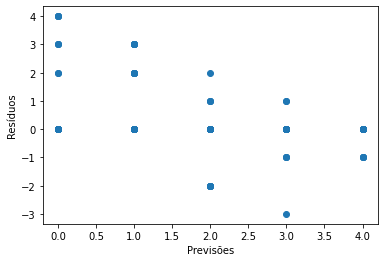

In [52]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## Decision Tree Classifier

In [53]:
# Modelo de Árvore de Decisão de Classificação.
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_treino, Y_treino)

DecisionTreeClassifier()

In [54]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_DTC.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Árvore de Decisão de Classificação:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Árvore de Decisão de Classificação:
Acurácia: 0.91
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        26
           1       1.00      0.80      0.89        10
           2       0.91      0.84      0.87        25
           3       0.81      0.95      0.88        37
           4       1.00      0.97      0.98        29

    accuracy                           0.91       127
   macro avg       0.94      0.89      0.91       127
weighted avg       0.92      0.91      0.91       127



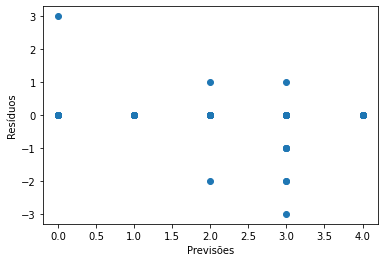

In [55]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## Random Forest Classifier

In [56]:
# Modelo de Regressão de Floresta Aleatória.
model_RFC = RandomForestClassifier()
model_RFC.fit(X_treino, Y_treino)

RandomForestClassifier()

In [71]:
# Avaliação do desempenho do modelo.
Y_pred = model_RFC.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Regressão de Floresta Aleatória:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Regressão de Floresta Aleatória:
Acurácia: 0.96
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.90      0.95        10
           2       1.00      0.84      0.91        25
           3       0.90      1.00      0.95        37
           4       1.00      1.00      1.00        29

    accuracy                           0.96       127
   macro avg       0.97      0.95      0.96       127
weighted avg       0.96      0.96      0.96       127



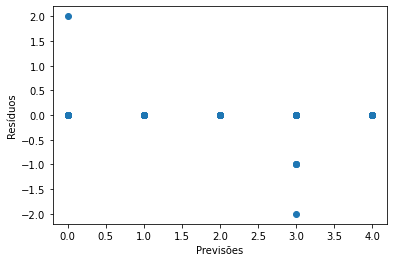

In [67]:
# Analisar os resíduos.
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

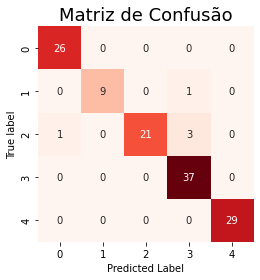

In [72]:
# Matriz de Confusão

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_teste, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

## XGBoost

In [60]:
# Modelo de Extreme Gradient Boosting.
model_XGB = XGBClassifier()
model_XGB.fit(X_treino, Y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [69]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_XGB.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Extreme Gradient Boosting:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Extreme Gradient Boosting:
Acurácia: 0.96
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.90      0.95        10
           2       0.95      0.84      0.89        25
           3       0.93      1.00      0.96        37
           4       1.00      1.00      1.00        29

    accuracy                           0.96       127
   macro avg       0.97      0.95      0.96       127
weighted avg       0.96      0.96      0.96       127



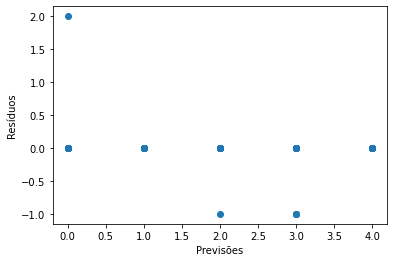

In [62]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

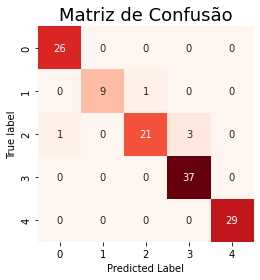

In [70]:
# Matriz de Confusão

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_teste, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

# Treinamento do Modelo

## Bootstraps

In [73]:
n_iterations = 100  # Número de iterações do Bootstrap

# Lista para armazenar as métricas de desempenho em cada iteração
performance_metrics = []

for _ in range(n_iterations):
    # Amostragem Bootstrap: crie um conjunto de treinamento com reamostragem
    indices_amostra = np.random.choice(len(X_treino), size=len(X_treino), replace=True)
    X_bootstrap = X_treino.iloc[indices_amostra]  
    y_bootstrap = Y_treino.iloc[indices_amostra]

    # Crie e treine seu modelo
    model_XGB.fit(X_bootstrap, y_bootstrap)

    # Avalie o modelo no conjunto de teste
    desempenho = model_XGB.score(X_teste, Y_teste)  # Mede a acurácia
    performance_metrics.append(desempenho)

In [74]:
# Calcule as métricas resumidas (por exemplo, média e desvio padrão)
media_desempenho = np.mean(performance_metrics)
desvio_padrao_desempenho = np.std(performance_metrics)

# Imprima as métricas resumidas
print(f'Média do desempenho: {media_desempenho:.4f}')
print(f'Desvio Padrão do desempenho: {desvio_padrao_desempenho:.4f}')

Média do desempenho: 0.9483
Desvio Padrão do desempenho: 0.0135


# Avaliação do Modelo

## Cross-Validation

In [76]:
# Número de classes
n_classes = 5

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [77]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 97.63%
Intervalo de acurácia: [94.17% ~ 101.08%]


In [78]:
# Calcule a média das pontuações para avaliação de Precisão do modelo
def intervalo_prec(results):
    mean = results.mean()
    dv = results.std()
    print('Precisão média: {:.2f}%'.format(mean * 100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='precision_macro') # Checar Modelo
intervalo_prec(scores)

Precisão média: 97.30%
Intervalo de Precisão: [93.32% ~ 101.28%]


In [79]:
# Calcule a média das pontuações para avaliação de Recall do modelo
def intervalo_recall(results):
    mean = results.mean()
    dv = results.std()
    print('Recall médio: {:.2f}%'.format(mean * 100))
    print('Intervalo de Recall: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='recall_macro') # Checar Modelo
intervalo_recall(scores)

Recall médio: 97.49%
Intervalo de Recall: [94.20% ~ 100.78%]


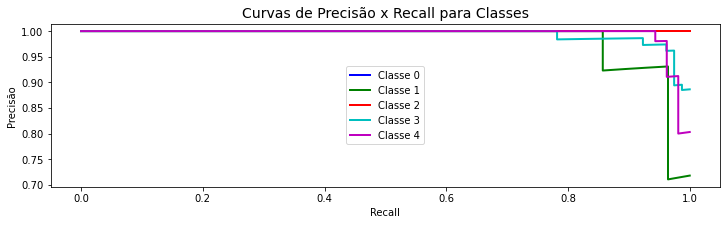

In [80]:
# Comparar scores de Previsão e Recall
# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas de precisão e recall para cada classe
precisions = dict()
recalls = dict()
for i in range(5):
    precision, recall, _ = precision_recall_curve(Y_bin[:, i], y_scores[:, i])
    precisions[i] = precision
    recalls[i] = recall

# Plote as curvas de precisão e recall para cada classe
fig, ax = plt.subplots(figsize=(12, 3))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(recalls[i], precisions[i], color, lw=2, label='Classe {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.legend(loc='center')
plt.title('Curvas de Precisão x Recall para Classes', fontsize=14)
plt.show()

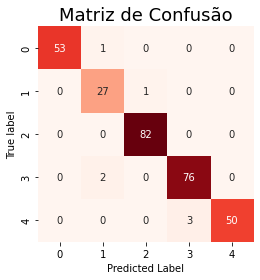

In [81]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

In [82]:
# Relatório do modelo
print('Relatório de classificação:\n', classification_report(Y_treino, Y_pred, digits=4))

Relatório de classificação:
               precision    recall  f1-score   support

           0     1.0000    0.9815    0.9907        54
           1     0.9000    0.9643    0.9310        28
           2     0.9880    1.0000    0.9939        82
           3     0.9620    0.9744    0.9682        78
           4     1.0000    0.9434    0.9709        53

    accuracy                         0.9763       295
   macro avg     0.9700    0.9727    0.9709       295
weighted avg     0.9771    0.9763    0.9764       295



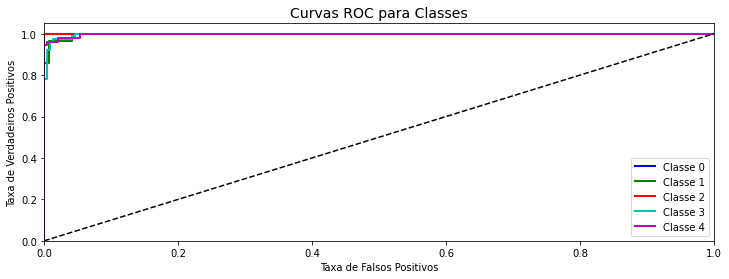

In [83]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para Classes', fontsize=14)
plt.show()

In [84]:
# Área sob a Curva
print('Área sob a curva ROC: {:.4f}'.format(roc_auc_score(Y_treino, y_scores, multi_class='ovr', average='macro')))

Área sob a curva ROC: 0.9988


In [85]:
# Treinamento do modelo 
model_XGB.fit(X_treino, Y_treino) # Checar modelo

# Fazer previsões no conjunto de teste
Y_pred_teste = model_XGB.predict(X_teste)

# Acurácia no conjunto de teste
accuracy = accuracy_score(Y_teste, Y_pred_teste)
print('Acurácia no conjunto de teste: {:.2f}%'.format(accuracy * 100))

# Precisão no conjunto de teste
precision = precision_score(Y_teste, Y_pred_teste, average='macro')
print('Precisão no conjunto de teste: {:.2f}%'.format(precision * 100))

# Recall no conjunto de teste
recall = recall_score(Y_teste, Y_pred_teste, average='macro')
print('Recall no conjunto de teste: {:.2f}%'.format(recall * 100))

# Relatório de classificação no conjunto de teste
print('Relatório de classificação no conjunto de teste:\n', classification_report(Y_teste, Y_pred_teste, digits=4))

Acurácia no conjunto de teste: 96.06%
Precisão no conjunto de teste: 96.85%
Recall no conjunto de teste: 94.80%
Relatório de classificação no conjunto de teste:
               precision    recall  f1-score   support

           0     0.9630    1.0000    0.9811        26
           1     1.0000    0.9000    0.9474        10
           2     0.9545    0.8400    0.8936        25
           3     0.9250    1.0000    0.9610        37
           4     1.0000    1.0000    1.0000        29

    accuracy                         0.9606       127
   macro avg     0.9685    0.9480    0.9566       127
weighted avg     0.9616    0.9606    0.9597       127



## Análise de Variáveis 

In [86]:
# Analisar variáveis que mais afetam o modelo
importances = model_XGB.feature_importances_

# Classifique as importâncias das características
indices_ordenados = np.argsort(importances)[::-1]

print(importances)

[0.04701998 0.0726851  0.05799179 0.01128593 0.0200376  0.01429147
 0.16355953 0.16360508 0.08978168 0.02732706 0.1509473  0.00170009
 0.00176249 0.17800489]


<Figure size 1440x1152 with 0 Axes>

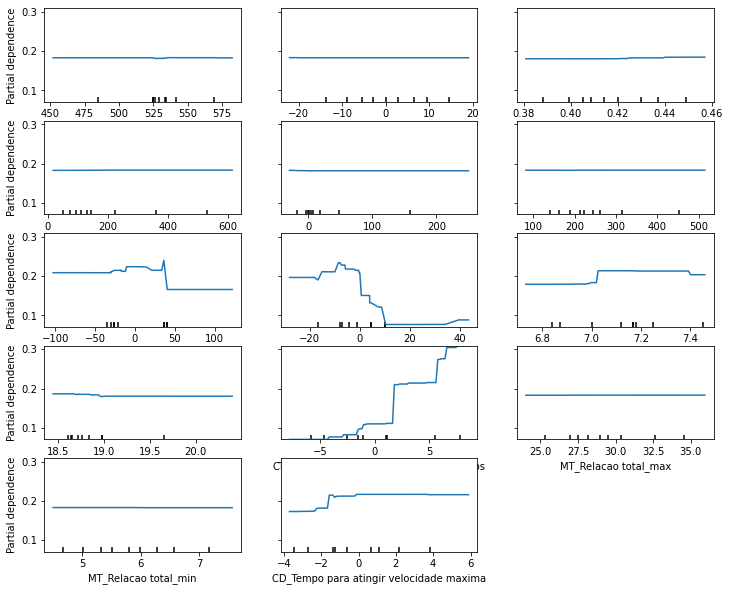

In [87]:
# Analisar como uma variável afeta as previsões
colunas = df.columns[:-1].tolist() # Separar as variáveis

plt.figure(figsize=(20, 16))

# Crie PDPs para as variáveis escolhidas
plot_partial_dependence(model_XGB, X_treino, features=colunas, target=Y_treino.all(), grid_resolution=100)

# Obter a figura atual e definir o tamanho
fig = plt.gcf()
fig.set_size_inches(12, 10)

plt.show()

[19:30:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


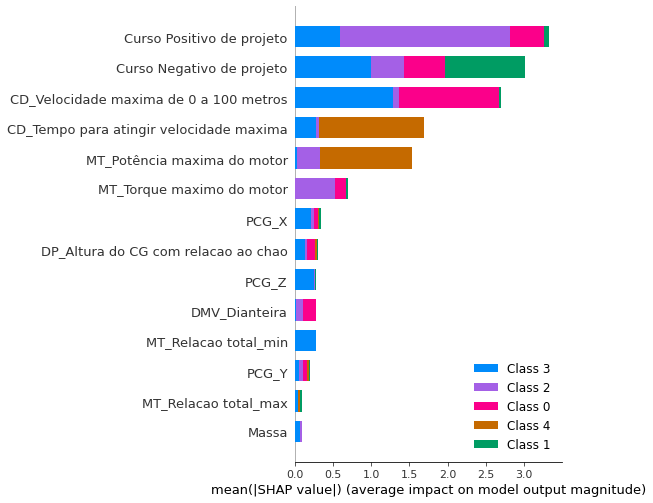

In [88]:
# Crie um objeto explainer
explainer = shap.Explainer(model_XGB, X_treino)

# Calcule os valores Shapley para um exemplo de dado específico
shap_values = explainer.shap_values(X_teste)

# Visualize os valores Shapley
shap.summary_plot(shap_values, X_teste)

# Aprimoramento de Parâmetros

## Tuning

In [89]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árvores na floresta
    'max_depth': [3, 4, 5],         # Profundidade máxima das árvores
    'learning_rate': [0.1, 0.01],   # Taxa de aprendizado
    'subsample': [0.8, 0.9, 1.0],   # Fração de amostras usadas para treinamento de cada árvore
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fração de colunas usadas para treinamento de cada árvore
    'min_child_weight': [1, 5, 10],  # Peso mínimo das amostras necessárias em uma folha
    'gamma': [0, 0.1, 0.2],         # Regularização gamma (parâmetro de penalização)
    'reg_alpha': [0, 0.1, 0.2],     # Regularização L1 (parâmetro de penalização)
    'reg_lambda': [1, 1.1, 1.2]     # Regularização L2 (parâmetro de penalização)
}

grid_search = GridSearchCV(estimator=model_XGB, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [90]:
# Guardar os parâmetros enconntrados fora do código
melhores_parametros = grid_search.best_params_

# Salvar os melhores parâmetros em um arquivo
joblib.dump(melhores_parametros, 'melhores_parametros_vel.pkl')

# Carregar os melhores parâmetros a partir do arquivo
#melhores_parametros = joblib.load('melhores_parametros_vel.pkl')

['melhores_parametros_vel.pkl']

In [91]:
# Ajustar um modelo de XGBoost
model_XGB.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_XGB.set_params(**best_params)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [92]:
# Avaliação do desempenho do modelo 
Y_pred = model_XGB.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Extreme Gradient Boosting:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Extreme Gradient Boosting:
Acurácia: 0.96
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.90      0.95        10
           2       0.95      0.84      0.89        25
           3       0.93      1.00      0.96        37
           4       1.00      1.00      1.00        29

    accuracy                           0.96       127
   macro avg       0.97      0.95      0.96       127
weighted avg       0.96      0.96      0.96       127



## Redução de Dimensão

In [ ]:
# Selecione um número específico de características mais importantes
num_caracteristicas_selecionadas = 3  # Por exemplo, selecione as 3 mais importantes

X_treino_selecionado = X_treino[:, indices_ordenados[:num_caracteristicas_selecionadas]]
X_teste_selecionado = X_teste[:, indices_ordenados[:num_caracteristicas_selecionadas]]

# Em seguida, treine seu modelo no conjunto de dados com características selecionadas
model_XGB.fit(X_treino_selecionado, Y_treino)

In [ ]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_XGB.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Extreme Gradient Boosting:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

# Predição

In [ ]:
# Valor único para fazer a previsão
X_prev = np.array([6]).reshape(-1, 1) # Colocar os valores pedidos

# Faça a previsão
previsao = modelo_carregado.predict(X_prev)

# Imprima a previsão
print(f'A previsão para X_prev é: {previsao[0]:.2f}')